<a href="https://colab.research.google.com/github/qkrwoghd04/multimodal_learning/blob/master/fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
audio_dataset_path = '/content/drive/MyDrive/audio_dataset'
image_dataset_path = '/content/drive/MyDrive/image_dataset'

In [2]:
import os
import itertools
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-white')


def load_audio_data(dataset_path, sr=22050):
    X, y = [], []
    max_length = 30000  # 3초 길이의 오디오에 대한 샘플 수

    for folder_name in ["non_scream", "scream"]:
        folder_path = os.path.join(dataset_path, folder_name)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                audio, _ = librosa.load(file_path, sr=sr)
                # 오디오를 max_length에 맞춤
                if len(audio) > max_length:
                    audio = audio[:max_length]
                else:
                    audio = np.pad(audio, (0, max_length - len(audio)), 'constant')

                X.append(audio)
                y.append(1 if folder_name == "scream" else 0)
            except Exception as e:
                print(f"파일 {file_path} 로드 중 오류 발생: {e}")

    return X, y, sr



<ipython-input-2-f09637c1a413>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [3]:
X,y,sr = load_audio_data(audio_dataset_path)
df = pd.DataFrame({"audio_data": X, "label": y})
df.shape

(423, 2)

In [4]:
X = np.vstack(X)
print(X.shape)

(423, 30000)


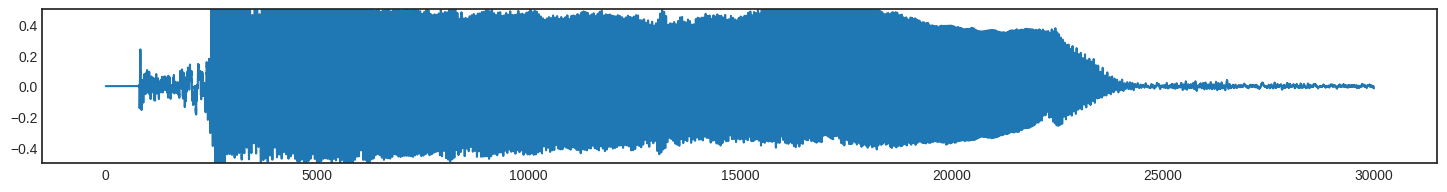

In [ ]:
plt.figure(figsize=(18,2))
plt.plot(X[2400])
plt.ylim((-0.5, 0.5))
plt.show()

In [5]:
def preprocess_audio(X, sr=22050):
  audio_cqt = []

  for i in X:
    ret = librosa.cqt(i, sr=sr, hop_length=256, n_bins=24*7, bins_per_octave=24)
    ret = np.abs(ret)
    audio_cqt.append(ret)

  cqt_np = np.array(audio_cqt, np.float32)
  inst_np = np.array(y, np.int16)
  cqt_np = cqt_np.reshape((423, 168*118))
  cqt_array = np.expand_dims(cqt_np, -1)

  return cqt_array, inst_np


In [6]:
from sklearn.model_selection import train_test_split

cqt_array, inst_np = preprocess_audio(X)
train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=469
  warnings.warn(


(338, 19824, 1)
(85, 19824, 1)
(338,)
(85,)


In [9]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout

def build_audio_submodel(input_shape):
  model = Sequential()

  model.add(Dense(256, activation='relu', input_shape=input_shape))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))


  return model


In [10]:
import glob
def load_image_data(dataset_path):
    X, y = [], []

    for folder_name in ['fall', 'stand']:
        folder_path = os.path.join(dataset_path, folder_name)

        file_path = os.path.join(folder_path, folder_path)

        # Use a loop to iterate over all matching files
        if folder_name == 'fall':
          images = glob.glob(f'{file_path}/*.jpg')
        else:
          images = glob.glob(f'{file_path}/*.png')
        for i in images:
          X.append(i)
          y.append(1 if folder_name == "fall" else 0)
    return X, y

In [11]:
X,y = load_image_data(image_dataset_path)

df = pd.DataFrame({'Image': X, 'label' : y})
df

,Image,label
0,/content/drive/MyDrive/image_dataset/fall/fall...,1
1,/content/drive/MyDrive/image_dataset/fall/fall...,1
2,/content/drive/MyDrive/image_dataset/fall/fall...,1
3,/content/drive/MyDrive/image_dataset/fall/fall...,1
4,/content/drive/MyDrive/image_dataset/fall/fall...,1
...,...,...
418,/content/drive/MyDrive/image_dataset/stand/sta...,0
419,/content/drive/MyDrive/image_dataset/stand/sta...,0
420,/content/drive/MyDrive/image_dataset/stand/sta...,0
421,/content/drive/MyDrive/image_dataset/stand/sta...,0


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)


In [14]:
trainDatagen = datagen.flow_from_directory(directory = image_dataset_path,
                                           target_size = (64, 64),
                                           class_mode = 'binary',
                                           batch_size = 64,
                                           subset='training')

Found 339 images belonging to 2 classes.


In [15]:
valDatagen = datagen.flow_from_directory(directory = image_dataset_path,
                                         target_size =(64, 64),
                                         class_mode = 'binary',
                                         batch_size = 64,
                                         subset='validation')

Found 84 images belonging to 2 classes.


In [16]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten

def build_image_submodel(input_shape):
    model = Sequential()
    # 입력층
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dense Layer(Fully-connected layer)
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))

    return model

In [34]:
def multimodal_generator(audio_data, image_generator, labels, batch_size):
    num_samples = len(audio_data)
    while True:
        for index in range(0, num_samples, batch_size):
            audio_batch = audio_data[index:index+batch_size]
            image_batch, labels_batch = next(image_generator)

           # 오디오 배치와 이미지 배치의 크기가 서로 다를 경우, 크기를 맞추어 조정
            batch_size_actual = min(len(audio_batch), len(image_batch))
            yield [audio_batch[:batch_size_actual], image_batch[:batch_size_actual]], labels_batch[:batch_size_actual]

In [35]:
train_generator = multimodal_generator(train_x, trainDatagen, train_y, 128)
validation_generator = multimodal_generator(test_x, valDatagen, test_y, 128)

In [36]:
from keras.layers import concatenate

def build_multimodal_model(audio_input_shape, image_input_shape):
    audio_model = build_audio_submodel(audio_input_shape)
    image_model = build_image_submodel(image_input_shape)  # image_model 정의 확인 필요

    combined_input = concatenate([audio_model.output, image_model.output])
    x = Dense(128, activation='relu')(combined_input)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[audio_model.input, image_model.input], outputs=output)
    return model


In [37]:
multimodal_model = build_multimodal_model(cqt_array.shape[1:], (64, 64, 3))
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# 훈련 데이터의 총 샘플 수
train_samples = len(train_x)
# 검증 데이터의 총 샘플 수
validation_samples = len(test_x)
# 배치 크기
batch_size = 128
# 한 에포크당 훈련 스텝의 수
steps_per_epoch = np.ceil(train_samples / batch_size)
# 한 에포크당 검증 스텝의 수
validation_steps = np.ceil(validation_samples / batch_size)

In [40]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
multimodal_model.fit(train_generator,
                     epochs=20,
                     steps_per_epoch=steps_per_epoch,
                     validation_data=validation_generator,
                     validation_steps=validation_steps,
                     callbacks=[early_stopping])

Epoch 1/20
3/3 [==============================] - 102s 40s/step - loss: 0.8596 - accuracy: 0.5312 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 65s 20s/step - loss: 0.7254 - accuracy: 0.5442 - val_loss: 0.6862 - val_accuracy: 0.5312
Epoch 3/20
3/3 [==============================] - 69s 23s/step - loss: 0.7269 - accuracy: 0.4948 - val_loss: 0.6852 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 58s 17s/step - loss: 0.6758 - accuracy: 0.5986 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 70s 24s/step - loss: 0.7078 - accuracy: 0.4948 - val_loss: 0.6860 - val_accuracy: 0.5500
Epoch 6/20
3/3 [==============================] - 56s 17s/step - loss: 0.7285 - accuracy: 0.4558 - val_loss: 0.6629 - val_accuracy: 0.6500
Epoch 7/20
3/3 [==============================] - 70s 24s/step - loss: 0.6736 - accuracy: 0.5729 - val_loss: 0.6800 - val_accuracy: 0.5500
Epoch 8/20
3/3 [==========